### Prepare data.csv
This notebook prepares the `data.csv` file containing the information required for performing train-test split on the images.

In [1]:
import os

import pandas as pd
import numpy as np
from IPython.display import Image 
from scipy import io


In [2]:
car_type = io.loadmat(os.path.join('misc', 'car_type.mat'))
type_id_to_name = {0: "unknown"}
for i, type_ in enumerate(car_type["types"][0], 1):
    type_id_to_name[i] = type_[0]

In [3]:
type_id_to_name

{0: 'unknown',
 1: 'MPV',
 2: 'SUV',
 3: 'sedan',
 4: 'hatchback',
 5: 'minibus',
 6: 'fastback',
 7: 'estate',
 8: 'pickup',
 9: 'hardtop convertible',
 10: 'sports',
 11: 'crossover',
 12: 'convertible'}

In [4]:
make_model_name = io.loadmat(os.path.join('misc', 'make_model_name.mat'))
make_id_to_name = {}
for i, make in enumerate(make_model_name['make_names']):
    make_id_to_name[i+1] = make[0][0] # labels start from 1

In [5]:
list(make_id_to_name.items())[:10]

[(1, 'ABT'),
 (2, 'BAC'),
 (3, 'Conquest'),
 (4, 'DS'),
 (5, 'Dacia'),
 (6, 'Fisker'),
 (7, 'GMC'),
 (8, 'Gumpert'),
 (9, 'Hennessey'),
 (10, 'Icona')]

In [6]:
def splitall(path):
    # return components of part
    # e.g. splitall("a\\b\\c") return ["a", "b", "c"]
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts

In [7]:
def display_img(path):
    # display image at path
    pil_img = Image(filename=path)
    display(pil_img)

In [8]:
def get_make_and_model(path):
    # path format: 'image/make_id/model_id/released_year/image_name.jpg'
    # return [make, model]
    return splitall(path)[1:3]

In [9]:
def get_label_path(img_path):
    # return label path derived from image path
    return img_path.replace("image", 'label').replace("jpg", "txt")

In [10]:
def get_label_info(img_path):
    """
    For label file:
    The first line is a number which is the viewpoint annotation (-1 - uncertain, 1 - front, 2 - rear, 3 - side, 4 - front-side, 5 - rear-side).
    The second line is the number of the bounding boxes, which is all '1' in the current release.
    The third line is the coordinates of the bounding box in the format 'x1 y1 x2 y2' in pixels, where 1 <= x1 < x2 <= image_width, and 1 <= y1 < y2 <= image_height.
    """
    # returns viewpoint, num_bb, x1, y1, x2, y2
    label_path = get_label_path(img_path)
    with open(get_label_path(ts_img_loc[0])) as f:
        viewpoint, num_bb, bb_coords = [line.strip() for line in f.readlines()]
        x1, y1, x2, y2 = bb_coords.split()
    return viewpoint, num_bb, x1, y1, x2, y2

In [11]:
tr_img_file = os.path.join('train_test_split', 'classification', 'train.txt')
ts_img_file = os.path.join('train_test_split', 'classification', 'test.txt')
with open(tr_img_file) as f:
    tr_img_loc = [os.path.join('image', line.strip().replace('/', os.sep)) for line in f.readlines()]
with open(ts_img_file) as f:
    ts_img_loc = [os.path.join('image', line.strip().replace('/', os.sep)) for line in f.readlines()]

In [12]:
attr_file = os.path.join('misc', 'attributes.txt')

In [13]:
with open(attr_file) as f:
    lines = [line.strip() for line in f.readlines()[1:]]
    map_model_to_attr = {}
    for line in lines:
        model, maximum_speed, displacement, door_number, seat_number, type_ = line.split()
        map_model_to_attr[model] = [maximum_speed, displacement, door_number, seat_number, type_]

In [14]:
rows = []
for i, split_img_loc in enumerate([ts_img_loc, tr_img_loc]):
    for img_loc in split_img_loc:
        train = False if i == 0 else True
        make, model = get_make_and_model(img_loc)
        _, _, x1, y1, x2, y2 = get_label_info(img_loc)
        maximum_speed, displacement, door_number, seat_number, type_ = map_model_to_attr[model]
        rows.append([
            train, img_loc, make, model,
            x1, y1, x2, y2,
            maximum_speed, displacement, door_number, seat_number, type_
        ])

In [15]:
for row in rows:
    assert len(row) == 13

In [16]:
df = pd.DataFrame(rows, columns=[
    "train", "img_path", "make", "model",
    "x1", "y1", "x2", "y2",
    "maximum_speed", "displacement", "door_number", "seat_number", "type"
])

In [17]:
df["type_name"] = df["type"].apply(lambda x: type_id_to_name[int(x)])
df["make_name"] = df["make"].apply(lambda x: make_id_to_name[int(x)])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30955 entries, 0 to 30954
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   train          30955 non-null  bool  
 1   img_path       30955 non-null  object
 2   make           30955 non-null  object
 3   model          30955 non-null  object
 4   x1             30955 non-null  object
 5   y1             30955 non-null  object
 6   x2             30955 non-null  object
 7   y2             30955 non-null  object
 8   maximum_speed  30955 non-null  object
 9   displacement   30955 non-null  object
 10  door_number    30955 non-null  object
 11  seat_number    30955 non-null  object
 12  type           30955 non-null  object
 13  type_name      30955 non-null  object
 14  make_name      30955 non-null  object
dtypes: bool(1), object(14)
memory usage: 3.3+ MB


In [19]:
df.head()

,train,img_path,make,model,x1,y1,x2,y2,maximum_speed,displacement,door_number,seat_number,type,type_name,make_name
0,False,image\78\1\2014\3ac218c0c6c378.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
1,False,image\78\1\2010\588feea1fcc809.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
2,False,image\78\1\2010\071c428717ceca.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
3,False,image\78\1\2010\4c119af3fdb787.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi
4,False,image\78\1\2014\1453dbb876c191.jpg,78,1,190,168,724,562,235,1.8,5,5,4,hatchback,Audi


In [20]:
df["make"].nunique()

75

In [21]:
df["model"].nunique()

431

In [22]:
df["make"] = df["make"].astype("int")
df["model"] = df["model"].astype("int")

In [23]:
def get_code_mapping(iterable):
    return {v: i for i, v in enumerate(sorted(set(iterable)))}

In [24]:
make_code_mapping = get_code_mapping(df["make"])
model_code_mapping = get_code_mapping(df["model"])

In [25]:
df["make_code"] = df["make"].map(make_code_mapping)
df["model_code"] = df["model"].map(model_code_mapping)

In [26]:
df.to_csv("data.csv", index=False)

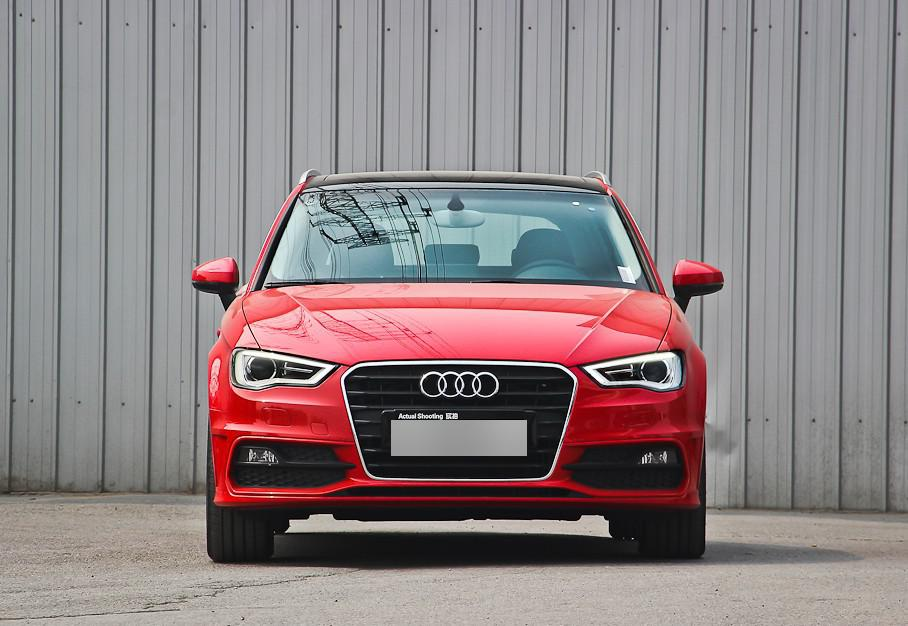

In [27]:
display_img(df.iloc[0, df.columns.get_loc('img_path')])